In [1]:
import sys
sys.path.append('../python/')
import ana
import ap
import aux
import cfg
import db
import fio
import lex

## Load basic data

In [2]:
corpus_id = cfg.CORPUS_ID_GC

In [3]:
db.connect(corpus_id)
# get wide table with basic data
df_bt = ap.load_data(cfg.NRM_SPK, ['gender'])
# get partner and non-partner speaker pairs
df_spk_pairs = db.pd_read_sql_query(sql_fname=cfg.SQL_SP_FNAME)
# limit to sessions and get entropy weights
df_spk_pairs_ses = df_spk_pairs[df_spk_pairs['tsk_id'] == 0]
df_spk_pairs_ses = lex.get_entropy_weights(corpus_id, df_spk_pairs_ses)
# get 25 most frequent types in the corpus
mf_types = lex.get_mf_types(corpus_id)
db.close()

## Compute/load acoustic measures

In [4]:
# local similarity
df_lsim, _ = fio.load_pickle_dumps(corpus_id, cfg.MEA_LSIM)
if df_lsim is None:
    df_lsim = ap.lsim(df_bt)
    fio.write_pickle_dumps(corpus_id, cfg.MEA_LSIM, df_lsim)

In [5]:
# synchrony
df_syn, _ = fio.load_pickle_dumps(corpus_id, cfg.MEA_SYN)
if df_syn is None:
    df_syn = ap.syn(df_bt)
    fio.write_pickle_dumps(corpus_id, cfg.MEA_SYN, df_syn)

In [6]:
# local convergence
df_lcon, _ = fio.load_pickle_dumps(corpus_id, cfg.MEA_LCON)
if df_lcon is None:
    df_lcon = ap.lcon(df_bt)
    fio.write_pickle_dumps(corpus_id, cfg.MEA_LCON, df_lcon)

In [7]:
# global convergence
df_gcon, df_gcon_raw = fio.load_pickle_dumps(corpus_id, cfg.MEA_GCON)
if df_gcon is None or df_gcon_raw is None:
    df_gcon, df_gcon_raw = ap.gcon(df_bt)    
    fio.write_pickle_dumps(
        corpus_id, cfg.MEA_GCON, df_gcon, df_gcon_raw)

In [8]:
# global similarity
df_gsim, df_gsim_raw = fio.load_pickle_dumps(corpus_id, cfg.MEA_GSIM)
if df_gsim is None or df_gsim_raw is None:
    df_gsim, df_gsim_raw = ap.gsim(df_bt, df_spk_pairs)
    fio.write_pickle_dumps(
        corpus_id, cfg.MEA_GSIM, df_gsim, df_gsim_raw)

## Compute/load lexical measures

In [9]:
# perplexity measure
df_ppl, df_ppl_raw = fio.load_pickle_dumps(corpus_id, cfg.MEA_PPL)
if df_ppl is None or df_ppl_raw is None:
    df_ppl, df_ppl_raw = lex.ppl(corpus_id, df_spk_pairs_ses)
    fio.write_pickle_dumps(corpus_id, cfg.MEA_PPL, df_ppl, df_ppl_raw)

In [10]:
# most frequent types measure
df_hfw, df_hfw_raw = fio.load_pickle_dumps(corpus_id, cfg.MEA_HFW)
if df_hfw is None or df_hfw_raw is None:
    df_hfw, df_hfw_raw = lex.dist_sim(
        corpus_id, df_spk_pairs_ses, 
        types_id=cfg.TYPES_ID_MF, types=mf_types)
    fio.write_pickle_dumps(corpus_id, cfg.MEA_HFW, df_hfw, df_hfw_raw)

In [11]:
# kullback-leibler divergence measure
df_kld, df_kld_raw = fio.load_pickle_dumps(corpus_id, cfg.MEA_KLD)
if df_kld is None or df_kld_raw is None:
    df_kld, df_kld_raw = lex.kld(corpus_id, df_spk_pairs_ses)
    fio.write_pickle_dumps(corpus_id, cfg.MEA_KLD, df_kld, df_kld_raw)

In [12]:
# task samples for further analysis (clustering and pca)
# (subset of measures as most are not meaningful for tasks)
dict_df_meas = {
    cfg.MEA_GSIM: df_gsim_raw,
    cfg.MEA_LSIM: df_lsim,
    cfg.MEA_SYN:  df_syn
}
df_samples_tsk, df_chi_tsk = ana.get_samples(
    df_bt, dict_df_meas, tsk_or_ses='tsk', nrm=True)

# Results overview

In [13]:
df_gsim

,intensity_mean,pitch_mean,rate_syl
ses_type,,,
0,"(1.2963193903929815, 0.20772231355448115, 23)","(0.14258608270519407, 0.8878588274762034, 23)","(0.06601963836317501, 0.9479327056291194, 23)"
GAME,"(1.2963193903929815, 0.20772231355448115, 23)","(0.14258608270519407, 0.8878588274762034, 23)","(0.06601963836317501, 0.9479327056291194, 23)"


In [14]:
df_gcon

,intensity_mean,pitch_mean,rate_syl
ses_type,,,
0,"(-1.0662880110648596, 0.3091377844668614, 11)","(0.8274807748633484, 0.42555224123415336, 11)","(-1.3563764063689825, 0.20216563782452895, 11)"
GAME,"(-1.0662880110648596, 0.3091377844668614, 11)","(0.8274807748633484, 0.42555224123415336, 11)","(-1.3563764063689825, 0.20216563782452895, 11)"


In [15]:
df_lsim.xs([0,0], level=[2,3])

intensity_mean  \
ses_type ses_id                                                      
GAME     0       (4.755617023986843, 2.116453732832298e-06, 204...   
         1       (0.7458413283439077, 0.4596417683652104, 45, -...   
         2       (1.7224578958043761, 0.08633670868721828, 229,...   
         3       (1.2327802210778382, 0.21914193178561206, 195,...   
         4       (1.2510567938212729, 0.21242036703115477, 194,...   
         5       (0.892225102706096, 0.3749819640211667, 79, -0...   
         6       (1.0364446438010362, 0.30209627806159584, 119,...   
         7       (2.4825129883489305, 0.0141331334713363, 152, ...   
         8       (1.5949667117372672, 0.11269307422875592, 160,...   
         9       (2.7616742797862535, 0.006327363420558751, 186...   
         10      (1.4016450255440982, 0.1618710359522366, 365, ...   
         11      (1.2052672927488544, 0.22967351413500475, 181,...   
         12      (0.41179345538719064, 0.6811689868754764, 130,...   

                                                        pitch_mean  \
ses_type ses_id                                                      
GAME     0       (1.454165954066411, 0.14605368006272085, 2046,...   
         1       (-0.4113669961745507, 0.6827561257487781, 45, ...   
         2       (0.7324417381121031, 0.46464798105822913, 229,...   
         3       (0.9526186031415386, 0.34196266025364874, 195,...   
         4       (-0.08002577246533722, 0.9362992493320555, 194...   
         5       (0.638908741849896, 0.5247304283489242, 79, -1...   
         6       (1.5083333272836292, 0.13411962953802437, 119,...   
         7       (1.3284938694039579, 0.18600610747291257, 152,...   
         8       (-0.6819866184163487, 0.4962334688726393, 160,...   
         9       (0.004870770270804121, 0.9961189230344278, 186...   
         10      (0.17761640367077514, 0.8591227683917848, 365,...   
         11      (1.009287234088783, 0.31418423624385794, 181, ...   
         12      (-0.46441797569107585, 0.643125145203286, 130,...   

                                                          rate_syl  
ses_type ses_id                                                     
GAME     0       (0.8637868541658426, 0.3878062394875429, 2046,...  
         1       (0.6418119647300486, 0.5242513408432878, 45, -...  
         2       (0.5273216647653757, 0.5984807257045636, 229, ...  
         3       (2.577681559549748, 0.010684428865263015, 195,...  
         4       (0.37388721640571815, 0.7088965227153361, 194,...  
         5       (0.5200707092174578, 0.6044686549904197, 79, -...  
         6       (0.02258063348592953, 0.9820226118674729, 119,...  
         7       (-0.18301317014073973, 0.855031569733871, 152,...  
         8       (-0.45059436601790614, 0.6528919295918062, 160...  
         9       (0.1208364144334269, 0.90395104150816, 186, -1...  
         10      (-0.3821193203331895, 0.7025952448587653, 365,...  
         11      (-0.7921152649619561, 0.429330392314183, 181, ...  
         12      (0.2582558608463631, 0.7966178640143143, 130, ...

In [16]:
df_lcon.xs([0,0], level=[2,3])

intensity_mean  \
ses_type ses_id                                                     
GAME     1           (0.14971188068648375, 0.320679571604451, 44)   
         2       (-0.026557413985472768, 0.6886856475514544, 228)   
         3        (-0.179743324900193, 0.011706319517296818, 194)   
         4          (0.00880237358331228, 0.902795627687555, 193)   
         5           (0.0968846610955616, 0.3925854457776684, 78)   
         6          (0.0515317247521871, 0.5761857772816683, 118)   
         7       (0.21068079498069903, 0.008948539162994098, 151)   
         8       (-0.024519650264854174, 0.7575180093188368, 159)   
         9        (0.07162380011762912, 0.32999439037069744, 185)   
         10      (0.1674282844404298, 0.0013050949295036114, 364)   
         11        (0.03436217356883353, 0.6451479485931485, 180)   
         12        (0.06679840650856916, 0.4484135959948384, 129)   

                                                        pitch_mean  \
ses_type ses_id                                                      
GAME     1          (0.23415250400336998, 0.11728852714065006, 44)   
         2       (-0.12350047821074348, 0.061492491145569456, 228)   
         3        (0.13890954953150975, 0.052171177894586585, 194)   
         4        (-0.005930393755774466, 0.9344226772056575, 193)   
         5           (0.06022223969148023, 0.5956622796893671, 78)   
         6          (0.08581734058673154, 0.3513557390919121, 118)   
         7        (-0.037959022006621324, 0.6413267226521417, 151)   
         8         (0.027028986308576267, 0.7335934968497435, 159)   
         9        (0.17976477974062907, 0.013822161057380149, 185)   
         10        (-0.00891762541336118, 0.8649912479949008, 364)   
         11       (0.19340371494043443, 0.008898537308488016, 180)   
         12      (-0.18039450905759524, 0.039220268822473155, 129)   

                                                         rate_syl  
ses_type ses_id                                                    
GAME     1        (-0.027325992136921478, 0.8569429843762326, 44)  
         2         (0.02915477366601876, 0.6600540722578524, 228)  
         3         (0.04250826723169748, 0.5541341064617552, 194)  
         4         (0.03163109540014511, 0.6606801879730998, 193)  
         5         (0.11011571906050098, 0.33086899584929697, 78)  
         6       (-0.10741186704990195, 0.24292618094851778, 118)  
         7        (0.022777151652065394, 0.7798890766829151, 151)  
         8        (0.12520993549193063, 0.11351462751161308, 159)  
         9         (0.1268185107786708, 0.08370550550280625, 185)  
         10       (0.009182262947542309, 0.8610247690638261, 364)  
         11       (-0.16678327797674714, 0.0244291414992036, 180)  
         12      (-0.09367416301143108, 0.28723076692110056, 129)

In [17]:
df_syn.xs([0,0], level=[2,3])

intensity_mean  \
ses_type ses_id                                                     
GAME     1         (0.18085544635058412, 0.22904865674220137, 44)   
         2       (0.2557197269772284, 8.764636913155228e-05, 228)   
         3         (0.1229814054241906, 0.08593321027374301, 194)   
         4          (0.126439033651325, 0.07817933084202495, 193)   
         5         (-0.04706901689467423, 0.6784331929525268, 78)   
         6       (-0.027164399333588985, 0.7683676231026249, 118)   
         7         (0.04859959307914034, 0.5507967912734006, 151)   
         8        (0.021846642189676923, 0.7832580609343097, 159)   
         9       (0.22343279705955826, 0.002113044914297602, 185)   
         10       (0.034777087088886736, 0.5071706808521562, 364)   
         11      (-0.014174052891613838, 0.8493792762125828, 180)   
         12       (-0.06168658971047784, 0.4839675649288054, 129)   

                                                       pitch_mean  \
ses_type ses_id                                                     
GAME     1          (-0.0694682236648918, 0.6464174169890363, 44)   
         2         (0.04600357199339221, 0.4875284930215937, 228)   
         3       (-0.06112648444675847, 0.39471758726582956, 194)   
         4       (-0.009796183531836828, 0.8918845069683407, 193)   
         5         (-0.03684147668758082, 0.7456017651906893, 78)   
         6       (0.19019953116253593, 0.037456118457044364, 118)   
         7        (0.10721903866887443, 0.18711689429305986, 151)   
         8        (-0.11380844945622651, 0.1505787500753031, 159)   
         9       (-0.005443824765614105, 0.9410544842660066, 185)   
         10       (-0.0446265781072392, 0.39462468863636524, 364)   
         11       (0.028657706373925267, 0.7009571399400455, 180)   
         12      (-0.007996383063048418, 0.9277730336459085, 129)   

                                                         rate_syl  
ses_type ses_id                                                    
GAME     1         (0.030727038580411453, 0.8393590625417074, 44)  
         2          (0.0207752176245954, 0.7539851704158987, 228)  
         3       (0.19723511509722183, 0.005590131579696284, 194)  
         4        (-0.03347606683001832, 0.6422232174511262, 193)  
         5         (0.16574399294519176, 0.14174842129994739, 78)  
         6         (0.09632758699578813, 0.2952808328782788, 118)  
         7        (0.011084363580713479, 0.8918325070726032, 151)  
         8       (-0.09001451059193293, 0.25613930022710363, 159)  
         9        (0.040102796609711444, 0.5857949891256055, 185)  
         10       (-0.02916345729334926, 0.5781154281670972, 364)  
         11        (-0.0385919327093145, 0.6049891536254186, 180)  
         12       (0.14205097697087307, 0.10555836892793123, 129)

In [18]:
df_ppl

,raw,wgh
ses_type,,
0,"(5.990611570146487, 4.1491891542355135e-06, 23)","(5.8183292465453125, 6.280601280189748e-06, 23)"
GAME,"(5.990611570146487, 4.1491891542355135e-06, 23)","(5.8183292465453125, 6.280601280189748e-06, 23)"


In [19]:
# average partner vs. average non-partner similarity, relative to stdev
p = df_ppl_raw.xs((0,0), level=(2,3))['ppl_p']
x = df_ppl_raw.xs((0,0), level=(2,3))['ppl_wgh_x']
(p.mean() - x.mean()) / ((p.std() + x.std()) / 2)

1.3417987207228772

In [20]:
df_hfw

,raw,wgh
ses_type,,
0,"(1.6883002146579627, 0.10486856473488275, 23)","(1.6690958989442823, 0.10865550611804828, 23)"
GAME,"(1.6883002146579627, 0.10486856473488275, 23)","(1.6690958989442823, 0.10865550611804828, 23)"


In [21]:
# average partner vs. average non-partner similarity, relative to stdev
p = df_hfw_raw.xs((0,0), level=(2,3))['dsim_p']
x = df_hfw_raw.xs((0,0), level=(2,3))['dsim_wgh_x']
(p.mean() - x.mean()) / ((p.std() + x.std()) / 2)

0.5154960970380378

In [22]:
df_kld

,raw,wgh
ses_type,,
0,"(10.851697882256214, 1.6000933629111125e-10, 23)","(10.707984999922756, 2.070991288164847e-10, 23)"
GAME,"(10.851697882256214, 1.6000933629111125e-10, 23)","(10.707984999922756, 2.070991288164847e-10, 23)"


In [23]:
# average partner vs. average non-partner similarity, relative to stdev
p = df_kld_raw.xs((0,0), level=(2,3))['kld_p']
x = df_kld_raw.xs((0,0), level=(2,3))['kld_wgh_x']
(p.mean() - x.mean()) / ((p.std() + x.std()) / 2)

3.1685787360389392

In [24]:
ana.bh(ana.correlate_columns(df_samples_tsk))

([('lsim_r', 'syn_r', 0.5367148656323097, 3.4374220195718042e-12),
  ('lsim_i', 'syn_i', 0.4976029847243798, 1.9216946062543611e-10),
  ('gsim_i', 'syn_i', 0.3663534343830914, 5.846291761077845e-06),
  ('lsim_p', 'syn_p', 0.306198357441269, 0.00017997748799368436),
  ('syn_p', 'syn_r', -0.23799610703984747, 0.00394424022963366)],
 [],
 [('gsim_i', 'syn_p', -0.17838291970123388, 0.031819418227763324),
  ('gsim_r', 'syn_i', 0.17302770318202343, 0.03741369304312786),
  ('gsim_i', 'lsim_i', 0.15659086635432715, 0.05998494906225891),
  ('syn_i', 'syn_r', 0.15033308227475894, 0.07109759790199073),
  ('gsim_i', 'gsim_r', 0.128157351572663, 0.12448833420430735),
  ('syn_i', 'syn_p', -0.12314555895794967, 0.14003593031180886),
  ('gsim_r', 'lsim_p', -0.12307153048884183, 0.1402761791364875),
  ('lsim_p', 'syn_i', -0.11294355072015658, 0.1761893779792266),
  ('gsim_p', 'lsim_p', 0.09620874482106953, 0.24966959511984857),
  ('lsim_p', 'syn_r', -0.0820269698203494, 0.32667133419056354),
  ('gsim_p

In [25]:
ana.bh(ana.chisquare(df_chi_tsk))

([('lsim_p_chi', 'syn_p_chi', 26.121081941405585, 3.20663689796945e-07),
  ('lsim_r_chi', 'syn_r_chi', 18.80634909535005, 1.4468467860849773e-05),
  ('gsim_i_chi', 'syn_i_chi', 13.50965791454922, 0.00023733880110365788),
  ('lsim_i_chi', 'syn_i_chi', 9.313402082991635, 0.0022748368661643543)],
 [],
 [('lsim_i_chi', 'lsim_r_chi', 2.8953359187118792, 0.08883625588844375),
  ('gsim_i_chi', 'lsim_i_chi', 2.3081375431716107, 0.12869817391148622),
  ('gsim_p_chi', 'lsim_r_chi', 2.0342430648129164, 0.15379072902089033),
  ('gsim_i_chi', 'gsim_r_chi', 1.5398184860522288, 0.21464482516758832),
  ('gsim_i_chi', 'lsim_r_chi', 1.3195001990008781, 0.25068176902908856),
  ('gsim_i_chi', 'syn_p_chi', 1.3195001990008781, 0.25068176902908856),
  ('gsim_p_chi', 'syn_r_chi', 1.0693333299583987, 0.30109607932104865),
  ('gsim_r_chi', 'syn_i_chi', 1.0042078888292914, 0.31629445966469577),
  ('gsim_r_chi', 'lsim_p_chi', 0.9649891452500559, 0.32593305910012793),
  ('lsim_r_chi', 'syn_p_chi', 0.85683000794526

In [26]:
kmeans = ana.kmeans(df_samples_tsk, 15, 100)

clustering real data
starting k=2 at Fri May  6 15:21:00 2022
starting k=3 at Fri May  6 15:21:01 2022
starting k=4 at Fri May  6 15:21:03 2022
starting k=5 at Fri May  6 15:21:04 2022
starting k=6 at Fri May  6 15:21:05 2022
starting k=7 at Fri May  6 15:21:07 2022
starting k=8 at Fri May  6 15:21:08 2022
starting k=9 at Fri May  6 15:21:10 2022
starting k=10 at Fri May  6 15:21:12 2022
starting k=11 at Fri May  6 15:21:13 2022
starting k=12 at Fri May  6 15:21:15 2022
starting k=13 at Fri May  6 15:21:17 2022
starting k=14 at Fri May  6 15:21:19 2022
starting k=15 at Fri May  6 15:21:22 2022
clustering shuffled data
starting k=2 at Fri May  6 15:21:24 2022
starting k=3 at Fri May  6 15:21:25 2022
starting k=4 at Fri May  6 15:21:26 2022
starting k=5 at Fri May  6 15:21:27 2022
starting k=6 at Fri May  6 15:21:29 2022
starting k=7 at Fri May  6 15:21:30 2022
starting k=8 at Fri May  6 15:21:32 2022
starting k=9 at Fri May  6 15:21:33 2022
starting k=10 at Fri May  6 15:21:35 2022
star

<IPython.core.display.Javascript object>


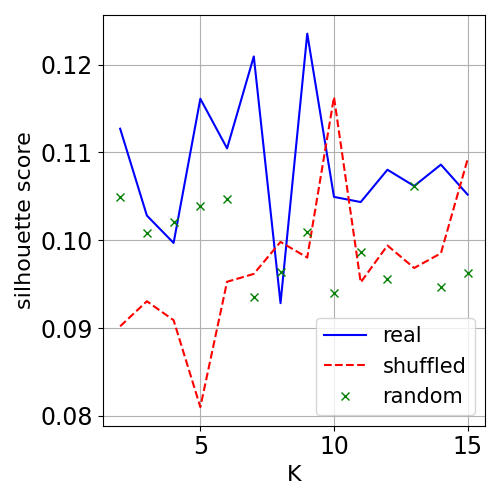

In [27]:
ana.plot_kmeans_scores(kmeans, 'sil')

In [28]:
import pickle
with open('../../data/gc/dumps/kmeans.pickle', 'wb') as pickle_file:
    pickle.dump(kmeans, pickle_file)

explained variance ratio per dimension:
 [0.21001033 0.16719709 0.14775296 0.11601611 0.10618423 0.09693185
 0.06974529 0.05232701 0.03383513]
dimensions required to retain 0.90 of variance: 7
dimensions required to retain 0.95 of variance: 8
dimensions required to retain 0.99 of variance: 9
fraction of variance retained in 3D: 0.5249603796820599


<IPython.core.display.Javascript object>


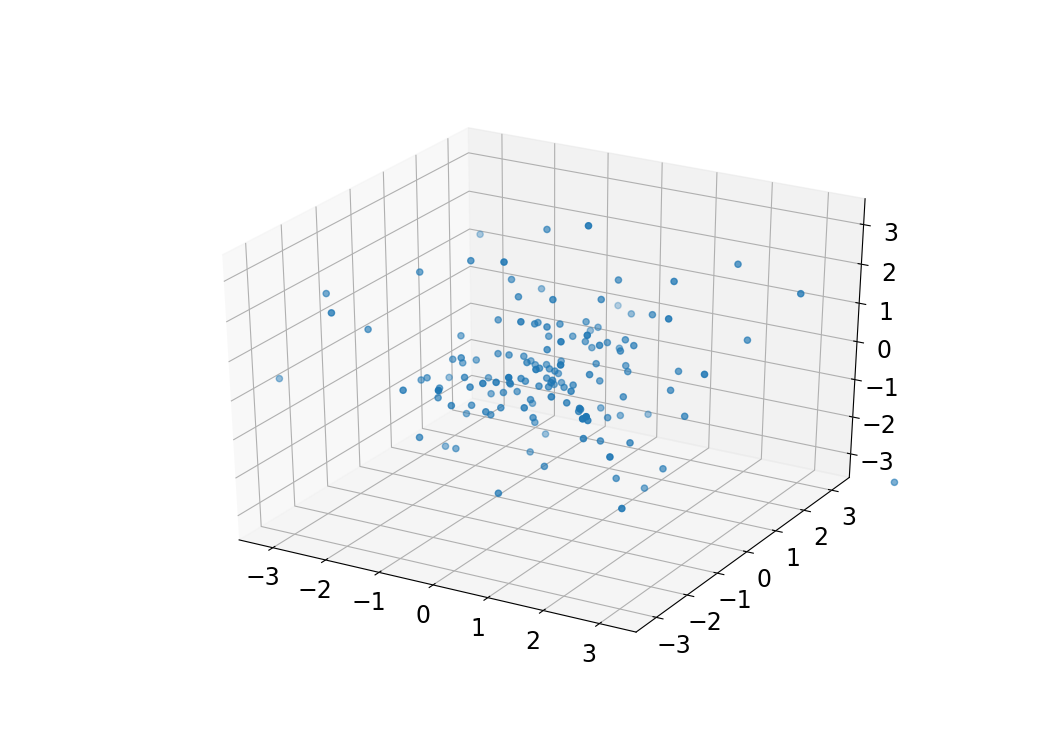

In [29]:
ana.pca(df_samples_tsk)

In [30]:
import pandas as pd
labels = kmeans[0]['kmeans'][0].labels_
gps = [v[3] for v in df_samples_tsk.index]
df_tmp = pd.DataFrame(zip(labels, gps, list(range(len(gps)))), 
                      columns=['lb', 'gp', '_'])
ana.chisquare(df_tmp, [0,1], ['f', 'm', 'x'], 1, 1)

[('lb',
  'gp',
  0.9834472291318607,
  0.6115713718950114,
  2,
  array([[19.22758621, 15.00689655, 33.76551724],
         [21.77241379, 16.99310345, 38.23448276]]),
  array([[20, 17, 31],
         [21, 15, 41]]))]

In [31]:
import pandas as pd
labels = kmeans[0]['kmeans'][1].labels_
gps = [v[3] for v in df_samples_tsk.index]
df_tmp = pd.DataFrame(zip(labels, gps, list(range(len(gps)))), 
                      columns=['lb', 'gp', '_'])
ana.chisquare(df_tmp, [0,1,2], ['f', 'm', 'x'], 1, 1)

[('lb',
  'gp',
  5.2215053798205,
  0.2653152763872124,
  4,
  array([[13.00689655, 10.15172414, 22.84137931],
         [11.59310345,  9.04827586, 20.35862069],
         [16.4       , 12.8       , 28.8       ]]),
  array([[14,  8, 24],
         [11,  6, 24],
         [16, 18, 24]]))]